# SGD Model Notebook

## Import necessary libraries 


In [29]:

import sys
# adding to the path variables the one folder higher (locally, not changing system variables)
sys.path.append("..")
import pandas as pd
# from pandas_profiling import ProfileReport
import numpy as np
import warnings
import mlflow
import gc
import seaborn as sns
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, Lasso, SGDRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score 
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from modeling.config import EXPERIMENT_NAME
from sklearn.pipeline import Pipeline
TRACKING_URI = open("../.mlflow_uri").read().strip()

ROOT = os.environ.get('PWD')

warnings.filterwarnings('ignore')

## Importing Data

In [30]:
# save to csv if desired: this is the normed, filtered set with agg price data for the years in question
master_dummies = pd.read_csv('../data/Master_dropped_dummies_on_head.csv')

## Modelling

In [31]:
# create X and Y sets for train test split
X = master_dummies.drop(['listing_id','inquiry_count'],axis=1)
Y = master_dummies['inquiry_count']

In [32]:
"""sgd_reg = SGDRegressor()
parameters = {'alpha': [1e-2, 1, 5]}
sgd_regressor = GridSearchCV(sgd_reg, parameters, scoring='neg_mean_squared_error', cv=2, verbose=5)"""

#[1e-15, 1e-10, 1e-8, 1e-3, 1e-2, 1, 5, 10, 20, 30, 35, 40, 45, 50, 100]

"sgd_reg = SGDRegressor()\nparameters = {'alpha': [1e-2, 1, 5]}\nsgd_regressor = GridSearchCV(sgd_reg, parameters, scoring='neg_mean_squared_error', cv=2, verbose=5)"

In [33]:
"""sgd_regressor.fit(X, Y)
print(sgd_regressor.best_params)
print(sgd_regressor.best_score)"""

'sgd_regressor.fit(X, Y)\nprint(sgd_regressor.best_params)\nprint(sgd_regressor.best_score)'

In [34]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [35]:
"""sns.displot(y_test-sgd_regressor)"""

'sns.displot(y_test-sgd_regressor)'

In [36]:
"""prediction_SGD = sgd_regressor(X_test)"""

'prediction_SGD = sgd_regressor(X_test)'

In [37]:
the_list = ['mean_price_per_day','adult_count','children_count','pets_count','length_stay','bathrooms','bedrooms','max_guests']

In [38]:
# Scaling with MinMaxScaler
scaler_norm = MinMaxScaler()
X_train_scaled_norm = scaler_norm.fit_transform(X_train[the_list])
X_test_scaled_norm = scaler_norm.transform(X_test[the_list])

In [39]:
# Concatenating normalized columns 
X_train_preprocessed_norm = np.concatenate([X_train_scaled_norm, X_train.drop(the_list, axis=1)], axis=1)
X_test_preprocessed_norm = np.concatenate([X_test_scaled_norm, X_test.drop(the_list, axis=1)], axis=1)

In [40]:
X_train_preprocessed_norm.shape

(1316826, 63)

In [41]:
X_test_preprocessed_norm.shape

(564354, 63)


## Trainining the model and tracking with MLFlow


In [42]:
# setting the MLFlow connection and experiment
mlflow.set_tracking_uri(TRACKING_URI)
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.start_run()
run = mlflow.active_run()

In [43]:
print("Active run_id: {}".format(run.info.run_id))

Active run_id: 1125445f7950436ab4ae117e6a945cba


In [44]:
#training the model
reg_sgd = SGDRegressor().fit(X_train_preprocessed_norm, y_train)

In [45]:
y_train_pred = reg_sgd.predict(X_train_preprocessed_norm)
rmse_train = mean_squared_error(y_train, y_train_pred,squared=False)
r2_train = r2_score(y_train, y_train_pred)
print(rmse_train)
print(r2_train)

1.438133932358071e+19
-4.620459877059708e+34


In [46]:
y_test_pred = reg_sgd.predict(X_test_preprocessed_norm)
rmse_test = mean_squared_error(y_test, y_test_pred,squared=False)
r2_test = r2_score(y_test, y_test_pred)
print(rmse_test)
print(r2_test)

1.4387123958331488e+19
-4.614359520265588e+34


## Validating model and visualizing model and residuals

In [47]:
#mean_absolute_error(y_test, y_test_pred)
#print(cross_val_score(reg_sgd, X, Y, cv=10, scoring='r2').mean())

In [48]:
y_residual = y_test - y_test_pred

In [49]:
plt.rcParams['agg.path.chunksize'] = 10000

<AxesSubplot:xlabel='inquiry_count'>

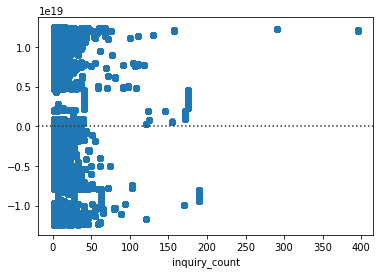

In [50]:
sns.residplot(x=y_test, y=y_test_pred)

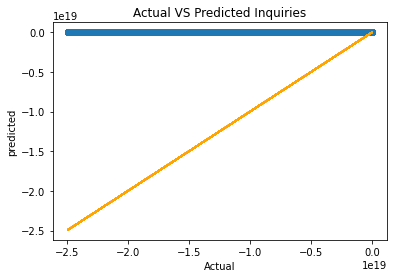

In [51]:
plt.scatter(y=y_test, x=y_test_pred)
plt.plot(y_test_pred, y_test_pred, color='orange')
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title(f'Actual VS Predicted Inquiries')
plt.show()

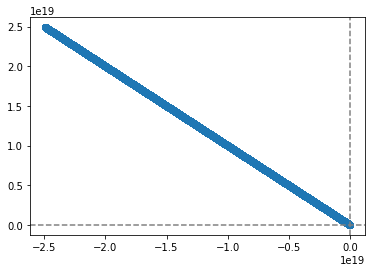

In [52]:
plt.axhline(0, c=(.5, .5, .5), ls='--')
plt.axvline(0, c=(.5, .5, .5), ls='--')
plt.scatter(x=y_test_pred, y=y_residual)

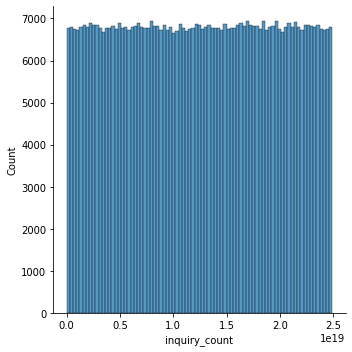

In [53]:
sns.displot(y_residual)

In [54]:
params = {
      "Model" : "SGD",
      "Folds this run": 5
      "train_test_split": 30,
      "normalized data": 'yes',
      "2019 and 2020 data": "2019", 
      "metric": 'rmse', 'r2'
      "cross_val_score": "yes", "no"
  }

SyntaxError: invalid syntax (3164372127.py, line 4)

In [ ]:
lflow.log_params(params)
mlflow.set_tag("running_from_jupyter", "Lasso model 2019")
mlflow.log_metric("train -" + "RMSE", rmse_train)
mlflow.log_metric("test -" + "RMSE", rmse_test)
# mlflow.log_artifact("../models")
# mlflow.sklearn.log_model(reg, "model")
mlflow.end_run()

In [ ]:
mlflow.get_run(run_id=run.info.run_id)

## Checking the experiments

In [ ]:
# while the next cell is running you will not be able to run other cells in the notebook
!mlflow ui